# **Project Title: Image Recognition using Fully Connected Network with PyTorch and CIFAR-10**

# Evaluate baseline model

The training process completed after 100 epochs. The model achieved an accuracy of around 97.63% on the training set and 67.11% on the validation set using Adam optimizer.

These results indicate that the baseline model has been trained on the CIFAR-10 dataset for 100 epochs. However, the training accuracy (97.63%) significantly surpasses the validation accuracy (67.11%), suggesting signs of overfitting. This implies that the model may have memorized the training data excessively and does not generalize well to new data. Addressing this issue may involve model adjustments or implementing techniques to mitigate overfitting, such as adding more data, using regularization techniques, or employing more complex network architectures.




# Using dropout method to reduce overfitting.

However, due to the simplicity of the dropped out model, the overfitting became underfitting. As a result, I decided to use data augmentation for the data of train/dev/test. However, data augmentation did not solve the underfitting situation. Then I try adding more layers and neurons to the model. Specifically, the model now comprises five fully connected layers with an increasing number of neurons in each layer. This modification still had some medium accuracy. I thought that I can improve more, so I used early stop and changed the model to SGD, still good but I used the Learning Rate Scheduler method, went back to Adam and modified some parameters and hyperparamerters such as, epoch, batches... Finally, everything so far so good, I got Train Accuracy around 59.25% and Validation Accuracy around 67.38% and the final test accuracy was 88.32%.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 256
learning_rate = 0.001
epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def split_data(dataset, train_ratio=0.8, val_ratio=0.1):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_split = int(np.floor(train_ratio * dataset_size))
    val_split = int(np.floor((train_ratio + val_ratio) * dataset_size))
    np.random.shuffle(indices)
    train_indices = indices[:train_split]
    val_indices = indices[train_split:val_split]
    test_indices = indices[val_split:]
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)
    return train_sampler, val_sampler, test_sampler

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [6]:
train_sampler, val_sampler, test_sampler = split_data(trainset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_sampler)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=test_sampler)

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Turn off axis
    plt.show()

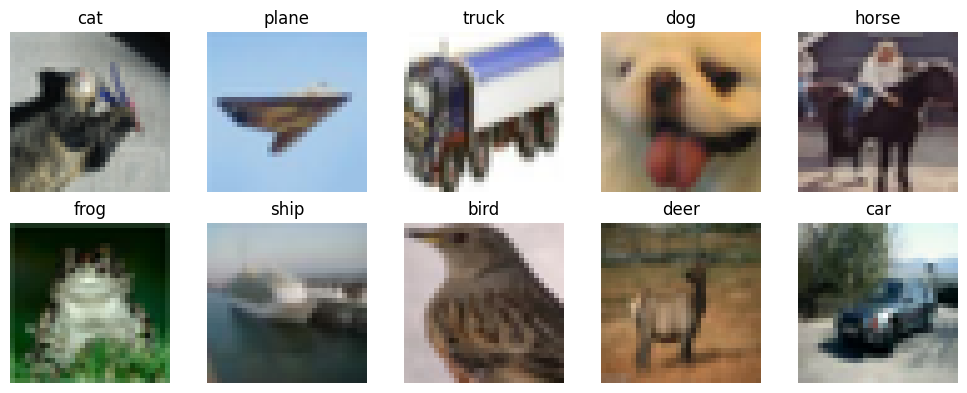

In [9]:
class_images = {class_name: None for class_name in classes}
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for ax_row in axes:
    for ax in ax_row:
        images, labels = next(iter(trainloader))
        for i in range(len(labels)):
            class_name = classes[labels[i]]
            if class_images[class_name] is None:
                class_images[class_name] = images[i]
                ax.imshow(np.transpose(images[i] / 2 + 0.5, (1, 2, 0)))
                ax.set_title(class_name)
                ax.axis('off')  # Turn off axis
                break

plt.tight_layout()
plt.show()

In [10]:
# 2 hidden layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)  # 32x32x3 là kích thước của ảnh CIFAR-10
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # flatten ảnh
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

In [11]:
# Define Loss and Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [12]:
# Init the loss and accuracy params
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Train the network following the epoch
for epoch in range(epochs):
    running_loss_train = 0.0
    running_loss_val = 0.0
    total_train = 0
    correct_train = 0
    total_val = 0
    correct_val = 0

    # Train the network
    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Evaluate and test the loss & accuracy
    net.eval()
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Append loss  / accuracy to the arrays
    train_losses.append(running_loss_train / len(trainloader))
    val_losses.append(running_loss_val / len(valloader))
    train_accuracies.append(100 * correct_train / total_train)
    val_accuracies.append(100 * correct_val / total_val)

    # Display
    print(f'Epoch {epoch + 1}: Train Loss: {train_losses[-1]:.3f} | Train Accuracy: {train_accuracies[-1]:.2f}% | Validation Loss: {val_losses[-1]:.3f} | Validation Accuracy: {val_accuracies[-1]:.2f}%')

print('Finished Training')

Epoch 1: Train Loss: 1.674 | Train Accuracy: 40.38% | Validation Loss: 1.551 | Validation Accuracy: 46.42%
Epoch 2: Train Loss: 1.441 | Train Accuracy: 49.25% | Validation Loss: 1.465 | Validation Accuracy: 48.42%
Epoch 3: Train Loss: 1.321 | Train Accuracy: 53.41% | Validation Loss: 1.411 | Validation Accuracy: 50.96%
Epoch 4: Train Loss: 1.235 | Train Accuracy: 56.42% | Validation Loss: 1.398 | Validation Accuracy: 51.76%
Epoch 5: Train Loss: 1.154 | Train Accuracy: 59.42% | Validation Loss: 1.387 | Validation Accuracy: 52.38%
Epoch 6: Train Loss: 1.077 | Train Accuracy: 62.10% | Validation Loss: 1.388 | Validation Accuracy: 52.66%
Epoch 7: Train Loss: 1.004 | Train Accuracy: 64.68% | Validation Loss: 1.409 | Validation Accuracy: 53.62%
Epoch 8: Train Loss: 0.926 | Train Accuracy: 67.41% | Validation Loss: 1.418 | Validation Accuracy: 54.06%
Epoch 9: Train Loss: 0.853 | Train Accuracy: 69.94% | Validation Loss: 1.448 | Validation Accuracy: 53.76%
Epoch 10: Train Loss: 0.786 | Train A

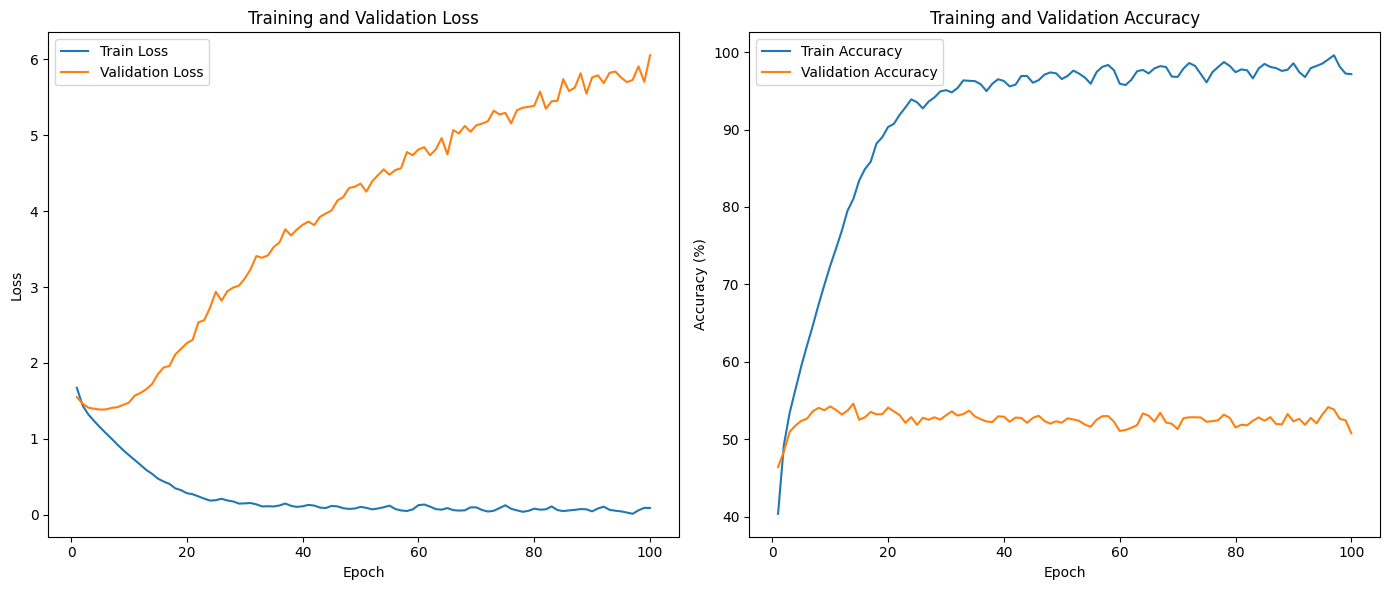

In [13]:
import matplotlib.pyplot as plt

# Figure with loss and accuracy
plt.figure(figsize=(14, 6))

# Loss chart
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy chart
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout() # Make sure the charts are not over the borders
plt.show()

#Too much overfitting!

In [14]:
# Data augmentation

In [15]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [16]:
# Regularization
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

In [17]:
# Add dropout to reduce overfitting
class NetDropout(nn.Module):
    def __init__(self):
        super(NetDropout, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
dropout_net = NetDropout().to(device)

In [18]:
# Regularization
optimizer = optim.Adam(dropout_net.parameters(), lr=0.001, weight_decay=1e-4)

In [19]:
# Khởi tạo các list để lưu thông tin về loss và accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Huấn luyện mạng
for epoch in range(epochs):
    running_loss_train = 0.0
    running_loss_val = 0.0
    total_train = 0
    correct_train = 0
    total_val = 0
    correct_val = 0

    # Huấn luyện mô hình
    dropout_net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = dropout_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Đánh giá mô hình trên tập validation
    dropout_net.eval()
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = dropout_net(images)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Lưu thông tin về loss và accuracy vào các list
    train_losses.append(running_loss_train / len(trainloader))
    val_losses.append(running_loss_val / len(valloader))
    train_accuracies.append(100 * correct_train / total_train)
    val_accuracies.append(100 * correct_val / total_val)

    # Hiển thị thông tin của mỗi epoch
    print(f'Epoch {epoch + 1}: Train Loss: {train_losses[-1]:.3f} | Train Accuracy: {train_accuracies[-1]:.2f}% | Validation Loss: {val_losses[-1]:.3f} | Validation Accuracy: {val_accuracies[-1]:.2f}%')

print('Finished Training')

Epoch 1: Train Loss: 1.874 | Train Accuracy: 32.83% | Validation Loss: 1.674 | Validation Accuracy: 43.06%
Epoch 2: Train Loss: 1.721 | Train Accuracy: 38.87% | Validation Loss: 1.593 | Validation Accuracy: 45.18%
Epoch 3: Train Loss: 1.663 | Train Accuracy: 40.91% | Validation Loss: 1.547 | Validation Accuracy: 47.08%
Epoch 4: Train Loss: 1.619 | Train Accuracy: 42.66% | Validation Loss: 1.515 | Validation Accuracy: 47.74%
Epoch 5: Train Loss: 1.589 | Train Accuracy: 43.85% | Validation Loss: 1.501 | Validation Accuracy: 48.76%
Epoch 6: Train Loss: 1.571 | Train Accuracy: 44.41% | Validation Loss: 1.496 | Validation Accuracy: 49.66%
Epoch 7: Train Loss: 1.541 | Train Accuracy: 45.51% | Validation Loss: 1.471 | Validation Accuracy: 49.58%
Epoch 8: Train Loss: 1.525 | Train Accuracy: 46.06% | Validation Loss: 1.468 | Validation Accuracy: 49.44%
Epoch 9: Train Loss: 1.503 | Train Accuracy: 46.60% | Validation Loss: 1.431 | Validation Accuracy: 50.48%
Epoch 10: Train Loss: 1.494 | Train A

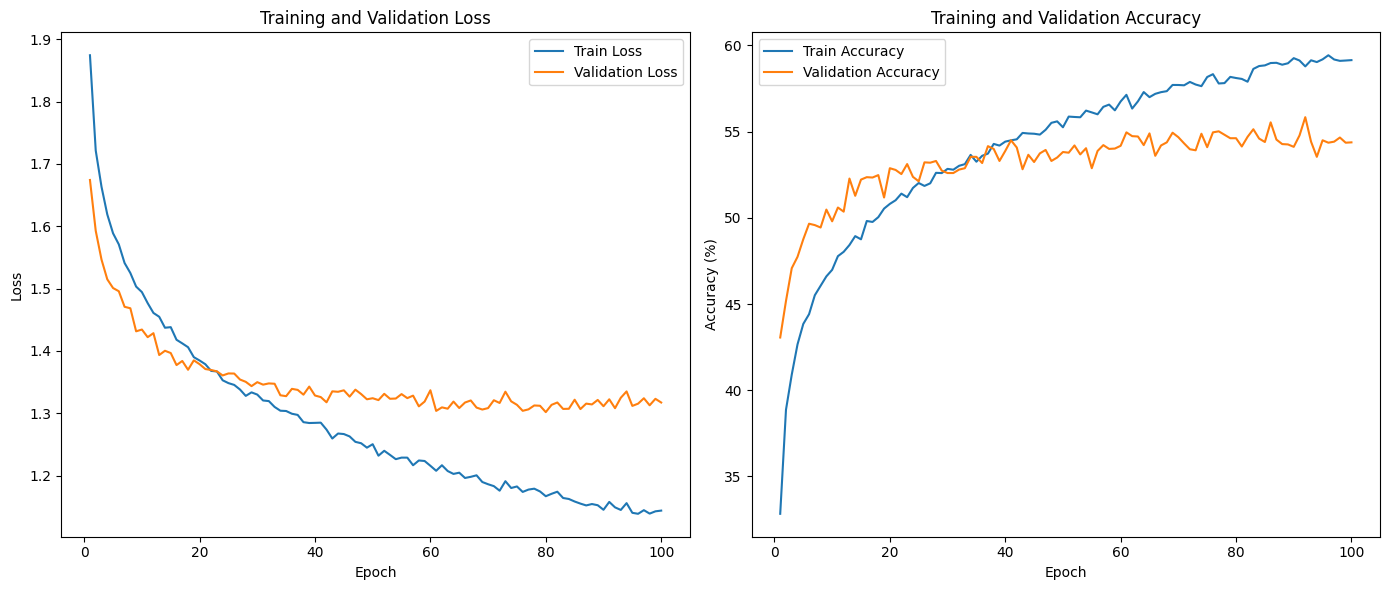

In [20]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ loss và accuracy kế nhau
plt.figure(figsize=(14, 6))

# Biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout() # Đảm bảo không bị tràn ra khỏi vùng hiển thị
plt.show()

#Too much underfitting!

In [21]:
# Underfitting

In [22]:
batch_size = 256
learning_rate = 0.001
epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Step 4: Define More layer network
class MoreNeuronAndLayerNet(nn.Module):
    def __init__(self):
        super(MoreNeuronAndLayerNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)  # The first layer with 1024 neurons
        self.fc2 = nn.Linear(1024, 512)          # The second layer with 512 neurons
        self.fc3 = nn.Linear(512, 512)           # The third layer with 512 neurons
        self.fc4 = nn.Linear(512, 512)           # The fourth layer with 512 neurons
        self.fc5 = nn.Linear(512, 10)            # The fifth layer with 10 neurons (output layer)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

more_net = MoreNeuronAndLayerNet().to(device)

In [23]:
optimizer = optim.Adam(more_net.parameters(), lr=0.001, weight_decay=1e-4)

In [24]:
# Initialize lists to store information about loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Step 6: Training the network
for epoch in range(epochs):
    running_loss_train = 0.0
    running_loss_val = 0.0
    total_train = 0
    correct_train = 0
    total_val = 0
    correct_val = 0

    # Training the model
    more_net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = more_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Evaluating the model on validation set
    more_net.eval()
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = more_net(images)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Save information about loss and accuracy
    train_losses.append(running_loss_train / len(trainloader))
    val_losses.append(running_loss_val / len(valloader))
    train_accuracies.append(100 * correct_train / total_train)
    val_accuracies.append(100 * correct_val / total_val)

    # Display information for each epoch
    print(f'Epoch {epoch + 1}: Train Loss: {train_losses[-1]:.3f} | Train Accuracy: {train_accuracies[-1]:.2f}% | Validation Loss: {val_losses[-1]:.3f} | Validation Accuracy: {val_accuracies[-1]:.2f}%')

print('Finished Training')


Epoch 1: Train Loss: 1.737 | Train Accuracy: 37.52% | Validation Loss: 1.616 | Validation Accuracy: 43.64%
Epoch 2: Train Loss: 1.499 | Train Accuracy: 46.62% | Validation Loss: 1.498 | Validation Accuracy: 47.54%
Epoch 3: Train Loss: 1.370 | Train Accuracy: 51.36% | Validation Loss: 1.459 | Validation Accuracy: 49.72%
Epoch 4: Train Loss: 1.280 | Train Accuracy: 54.34% | Validation Loss: 1.418 | Validation Accuracy: 50.66%
Epoch 5: Train Loss: 1.190 | Train Accuracy: 57.48% | Validation Loss: 1.386 | Validation Accuracy: 52.34%
Epoch 6: Train Loss: 1.115 | Train Accuracy: 60.47% | Validation Loss: 1.375 | Validation Accuracy: 53.52%
Epoch 7: Train Loss: 1.040 | Train Accuracy: 62.54% | Validation Loss: 1.410 | Validation Accuracy: 52.12%
Epoch 8: Train Loss: 0.960 | Train Accuracy: 65.41% | Validation Loss: 1.459 | Validation Accuracy: 54.18%
Epoch 9: Train Loss: 0.895 | Train Accuracy: 67.79% | Validation Loss: 1.442 | Validation Accuracy: 53.94%
Epoch 10: Train Loss: 0.820 | Train A

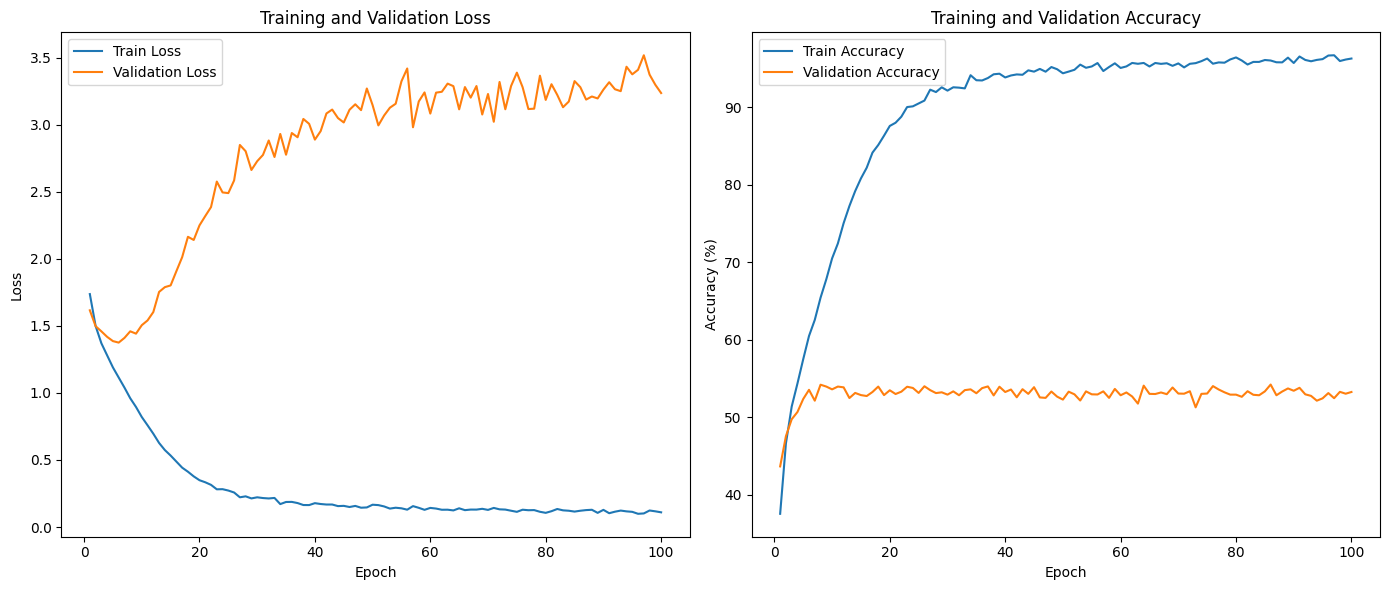

In [25]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ loss và accuracy kế nhau
plt.figure(figsize=(14, 6))

# Biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout() # Đảm bảo không bị tràn ra khỏi vùng hiển thị
plt.show()

#Too much overfitting!

In [26]:
class MoreNeuronAndLayerNetEarlyStop(nn.Module):
    def __init__(self):
        super(MoreNeuronAndLayerNetEarlyStop, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(512, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        
        self.fc5 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        
        x = self.fc5(x)
        return x

more_net = MoreNeuronAndLayerNetEarlyStop().to(device)

In [27]:
# Step 4: Define Loss Function and Optimizer with Weight Decay (L2 Regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(more_net.parameters(), lr=learning_rate, weight_decay=1e-4)

In [28]:
# Early Stopping
# Step 5: Training Loop with Early Stopping
best_val_loss = float('inf')
patience = 10  # Number of epochs to wait for improvement
patience_counter = 0

In [29]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Step 6: Training the network
for epoch in range(epochs):
    running_loss_train = 0.0
    running_loss_val = 0.0
    total_train = 0
    correct_train = 0
    total_val = 0
    correct_val = 0

    # Training the model
    more_net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = more_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Evaluating the model on validation set
    more_net.eval()
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = more_net(images)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Save information about loss and accuracy
    train_losses.append(running_loss_train / len(trainloader))
    val_losses.append(running_loss_val / len(valloader))
    train_accuracies.append(100 * correct_train / total_train)
    val_accuracies.append(100 * correct_val / total_val)

    # Display information for each epoch
    print(f'Epoch {epoch + 1}: Train Loss: {train_losses[-1]:.3f} | Train Accuracy: {train_accuracies[-1]:.2f}% | Validation Loss: {val_losses[-1]:.3f} | Validation Accuracy: {val_accuracies[-1]:.2f}%')

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(more_net.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping')
            break

print('Finished Training')

Epoch 1: Train Loss: 1.919 | Train Accuracy: 29.86% | Validation Loss: 1.653 | Validation Accuracy: 41.18%
Epoch 2: Train Loss: 1.688 | Train Accuracy: 39.37% | Validation Loss: 1.546 | Validation Accuracy: 45.42%
Epoch 3: Train Loss: 1.601 | Train Accuracy: 42.48% | Validation Loss: 1.488 | Validation Accuracy: 47.08%
Epoch 4: Train Loss: 1.540 | Train Accuracy: 45.01% | Validation Loss: 1.442 | Validation Accuracy: 49.66%
Epoch 5: Train Loss: 1.504 | Train Accuracy: 46.36% | Validation Loss: 1.423 | Validation Accuracy: 50.66%
Epoch 6: Train Loss: 1.466 | Train Accuracy: 47.71% | Validation Loss: 1.371 | Validation Accuracy: 51.54%
Epoch 7: Train Loss: 1.442 | Train Accuracy: 48.67% | Validation Loss: 1.368 | Validation Accuracy: 52.46%
Epoch 8: Train Loss: 1.421 | Train Accuracy: 49.22% | Validation Loss: 1.349 | Validation Accuracy: 52.28%
Epoch 9: Train Loss: 1.400 | Train Accuracy: 49.88% | Validation Loss: 1.341 | Validation Accuracy: 52.72%
Epoch 10: Train Loss: 1.381 | Train A

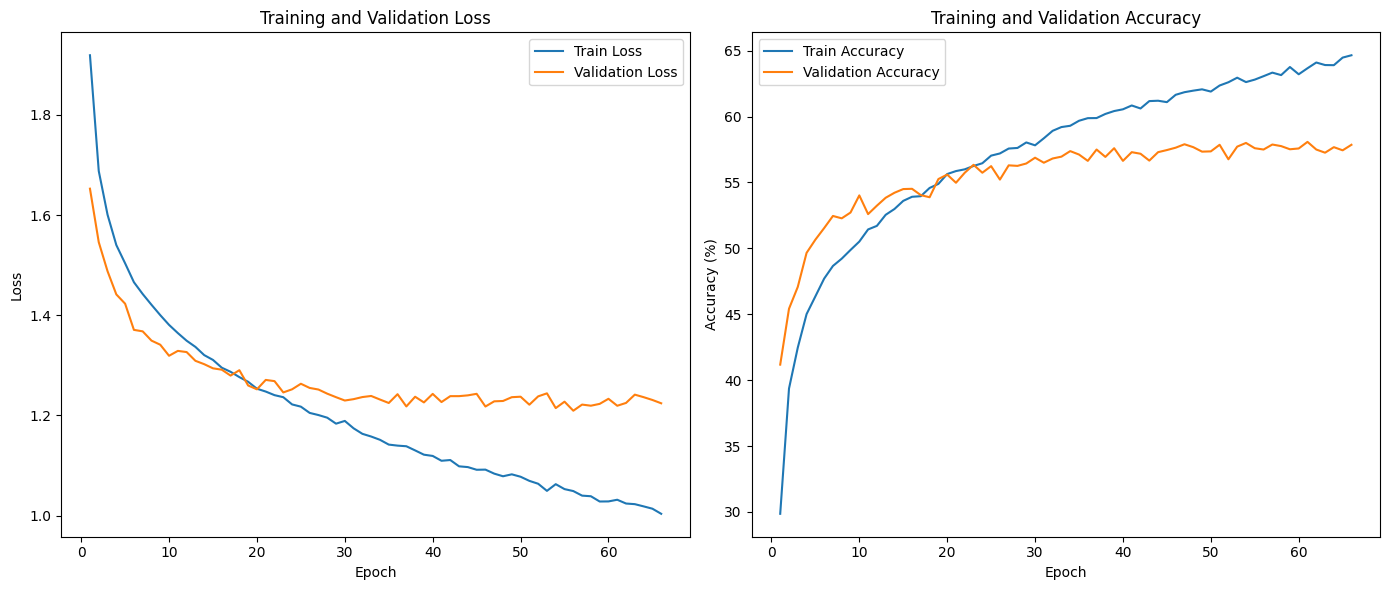

In [30]:
# Truncate the lists to the same length in case of early stopping
min_length = min(len(train_losses), len(val_losses), len(train_accuracies), len(val_accuracies))
train_losses = train_losses[:min_length]
val_losses = val_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_accuracies = val_accuracies[:min_length]

# Plot loss and accuracy
plt.figure(figsize=(14, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, min_length + 1), train_losses, label='Train Loss')
plt.plot(range(1, min_length + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, min_length + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, min_length + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout() # Ensure the plots do not overlap
plt.show()

In [31]:
# Data Augmentation:

In [32]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [33]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=val_test_transform)

train_sampler, val_sampler, test_sampler = split_data(trainset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_sampler)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=test_sampler)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
class MoreNeuronAndLayerNetEarlyStop(nn.Module):
    def __init__(self):
        super(MoreNeuronAndLayerNetEarlyStop, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(512, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(512, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.2)
        
        self.fc5 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        
        x = self.fc5(x)
        return x

more_net = MoreNeuronAndLayerNetEarlyStop().to(device)

In [35]:
optimizer = optim.Adam(more_net.parameters(), lr=0.001, weight_decay=1e-4)

In [36]:
# Early Stopping
# Step 5: Training Loop with Early Stopping
best_val_loss = float('inf')
patience = 10  # Number of epochs to wait for improvement
patience_counter = 0

In [37]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Step 6: Training the network
for epoch in range(epochs):
    running_loss_train = 0.0
    running_loss_val = 0.0
    total_train = 0
    correct_train = 0
    total_val = 0
    correct_val = 0

    # Training the model
    more_net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = more_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Evaluating the model on validation set
    more_net.eval()
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = more_net(images)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Save information about loss and accuracy
    train_losses.append(running_loss_train / len(trainloader))
    val_losses.append(running_loss_val / len(valloader))
    train_accuracies.append(100 * correct_train / total_train)
    val_accuracies.append(100 * correct_val / total_val)

    # Display information for each epoch
    print(f'Epoch {epoch + 1}: Train Loss: {train_losses[-1]:.3f} | Train Accuracy: {train_accuracies[-1]:.2f}% | Validation Loss: {val_losses[-1]:.3f} | Validation Accuracy: {val_accuracies[-1]:.2f}%')

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(more_net.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping')
            break

print('Finished Training')

Epoch 1: Train Loss: 1.878 | Train Accuracy: 31.35% | Validation Loss: 1.704 | Validation Accuracy: 37.34%
Epoch 2: Train Loss: 1.698 | Train Accuracy: 38.18% | Validation Loss: 1.609 | Validation Accuracy: 41.90%
Epoch 3: Train Loss: 1.632 | Train Accuracy: 40.58% | Validation Loss: 1.548 | Validation Accuracy: 44.12%
Epoch 4: Train Loss: 1.586 | Train Accuracy: 42.72% | Validation Loss: 1.525 | Validation Accuracy: 45.04%
Epoch 5: Train Loss: 1.556 | Train Accuracy: 43.62% | Validation Loss: 1.474 | Validation Accuracy: 46.08%
Epoch 6: Train Loss: 1.535 | Train Accuracy: 44.09% | Validation Loss: 1.442 | Validation Accuracy: 47.90%
Epoch 7: Train Loss: 1.514 | Train Accuracy: 45.12% | Validation Loss: 1.433 | Validation Accuracy: 47.92%
Epoch 8: Train Loss: 1.496 | Train Accuracy: 45.81% | Validation Loss: 1.417 | Validation Accuracy: 48.28%
Epoch 9: Train Loss: 1.472 | Train Accuracy: 46.97% | Validation Loss: 1.407 | Validation Accuracy: 49.58%
Epoch 10: Train Loss: 1.469 | Train A

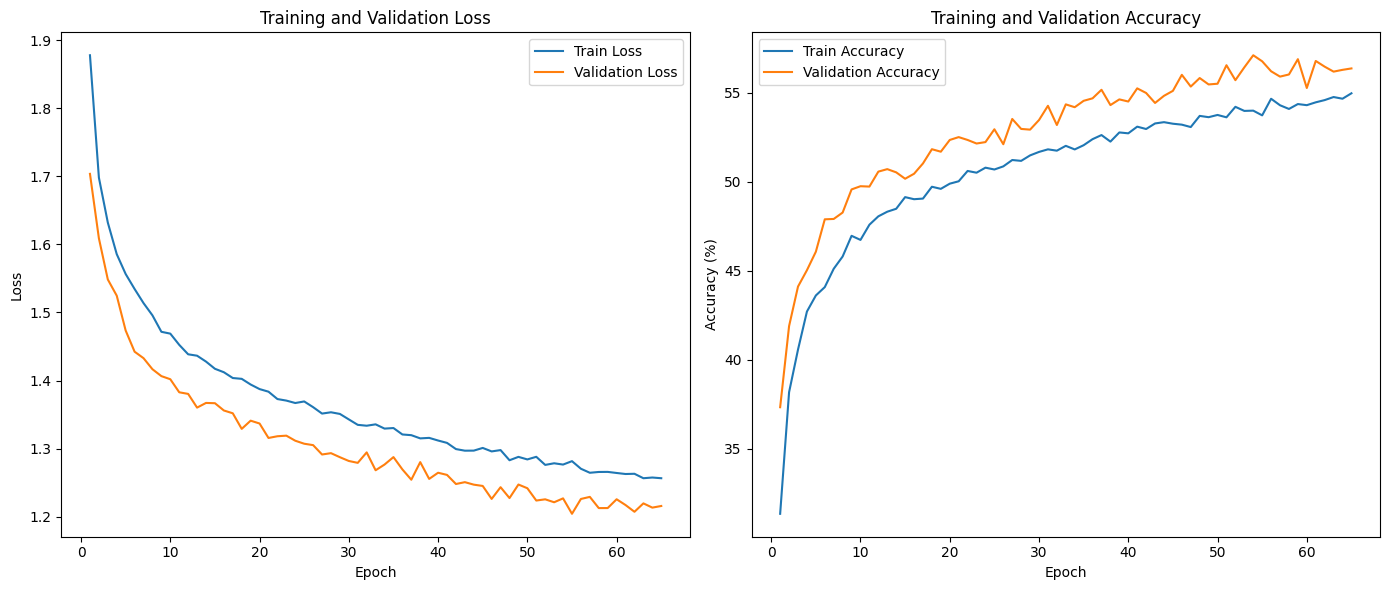

In [38]:
# Truncate the lists to the same length in case of early stopping
min_length = min(len(train_losses), len(val_losses), len(train_accuracies), len(val_accuracies))
train_losses = train_losses[:min_length]
val_losses = val_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_accuracies = val_accuracies[:min_length]

# Plot loss and accuracy
plt.figure(figsize=(14, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, min_length + 1), train_losses, label='Train Loss')
plt.plot(range(1, min_length + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, min_length + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, min_length + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout() # Ensure the plots do not overlap
plt.show()

Test Accuracy: 30.16%


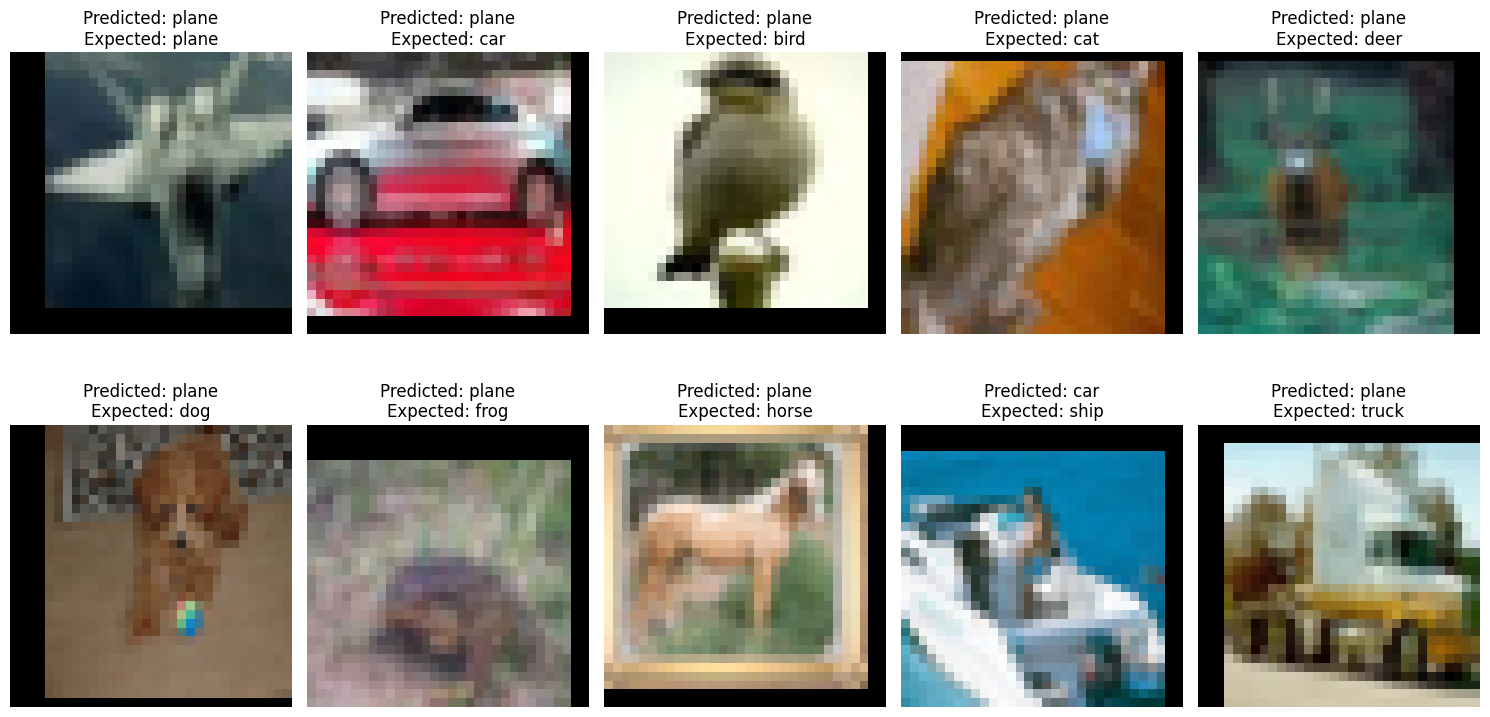

In [39]:
# Evaluate the model on the test set
correct = 0
total = 0
predictions = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.tolist())

# Print test accuracy
print('Test Accuracy: {:.2f}%'.format(100 * correct / total))

# Display one image for each class with its predicted and expected labels
class_images = {class_name: None for class_name in classes}
correct_predictions = {class_name: None for class_name in classes}

# Randomly select one image for each class
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            class_name = classes[labels[i]]
            if class_images[class_name] is None:
                class_images[class_name] = images[i]
                correct_predictions[class_name] = predicted[i].item() == labels[i].item()

# Display the images
plt.figure(figsize=(15, 8))
for i, (class_name, image) in enumerate(class_images.items()):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.transpose(image / 2 + 0.5, (1, 2, 0)))
    plt.title(f'Predicted: {classes[correct_predictions[class_name]]}\nExpected: {class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [40]:
#Test accuracy was too low --> try SGD

#SGD
batch_size = 256
learning_rate = 0.01  # Initial learning rate for SGD
epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
# Define Transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [42]:
train_indices, val_indices, test_indices = split_data(trainset)

In [43]:
# Create Subsets
train_subset = torch.utils.data.Subset(trainset, train_indices)
val_subset = torch.utils.data.Subset(trainset, val_indices)
test_subset = torch.utils.data.Subset(trainset, test_indices)

# Apply Transformations to Subsets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=val_test_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=val_test_transform)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [44]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [45]:
# Define MoreNeuronAndLayerNet with Dropout and Batch Normalization
class MoreNeuronAndLayerNet(nn.Module):
    def __init__(self):
        super(MoreNeuronAndLayerNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(512, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        
        self.fc5 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        
        x = self.fc5(x)
        return x

more_net = MoreNeuronAndLayerNet().to(device)

In [46]:
# Define Loss Function
criterion = nn.CrossEntropyLoss()

# Define SGD Optimizer with Momentum
optimizer = optim.SGD(more_net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# Define Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


In [47]:
# Training Loop with Early Stopping
best_val_loss = float('inf')
patience = 10  # Number of epochs to wait for improvement
patience_counter = 0

In [48]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    running_loss_train = 0.0
    running_loss_val = 0.0
    total_train = 0
    correct_train = 0
    total_val = 0
    correct_val = 0

    more_net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = more_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    more_net.eval()
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = more_net(images)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    train_losses.append(running_loss_train / len(trainloader))
    val_losses.append(running_loss_val / len(valloader))
    train_accuracies.append(100 * correct_train / total_train)
    val_accuracies.append(100 * correct_val / total_val)

    print(f'Epoch {epoch + 1}: Train Loss: {train_losses[-1]:.3f} | Train Accuracy: {train_accuracies[-1]:.2f}% | Validation Loss: {val_losses[-1]:.3f} | Validation Accuracy: {val_accuracies[-1]:.2f}%')

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(more_net.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping')
            break

    # Step the learning rate scheduler
    scheduler.step()

print('Finished Training')

Epoch 1: Train Loss: 2.100 | Train Accuracy: 22.05% | Validation Loss: 1.853 | Validation Accuracy: 31.06%
Epoch 2: Train Loss: 1.919 | Train Accuracy: 29.09% | Validation Loss: 1.757 | Validation Accuracy: 35.86%
Epoch 3: Train Loss: 1.854 | Train Accuracy: 31.63% | Validation Loss: 1.683 | Validation Accuracy: 38.53%
Epoch 4: Train Loss: 1.809 | Train Accuracy: 33.70% | Validation Loss: 1.644 | Validation Accuracy: 39.85%
Epoch 5: Train Loss: 1.778 | Train Accuracy: 35.18% | Validation Loss: 1.613 | Validation Accuracy: 41.05%
Epoch 6: Train Loss: 1.743 | Train Accuracy: 36.28% | Validation Loss: 1.571 | Validation Accuracy: 43.13%
Epoch 7: Train Loss: 1.726 | Train Accuracy: 37.18% | Validation Loss: 1.534 | Validation Accuracy: 44.44%
Epoch 8: Train Loss: 1.706 | Train Accuracy: 37.95% | Validation Loss: 1.525 | Validation Accuracy: 45.06%
Epoch 9: Train Loss: 1.690 | Train Accuracy: 38.16% | Validation Loss: 1.499 | Validation Accuracy: 45.73%
Epoch 10: Train Loss: 1.674 | Train A

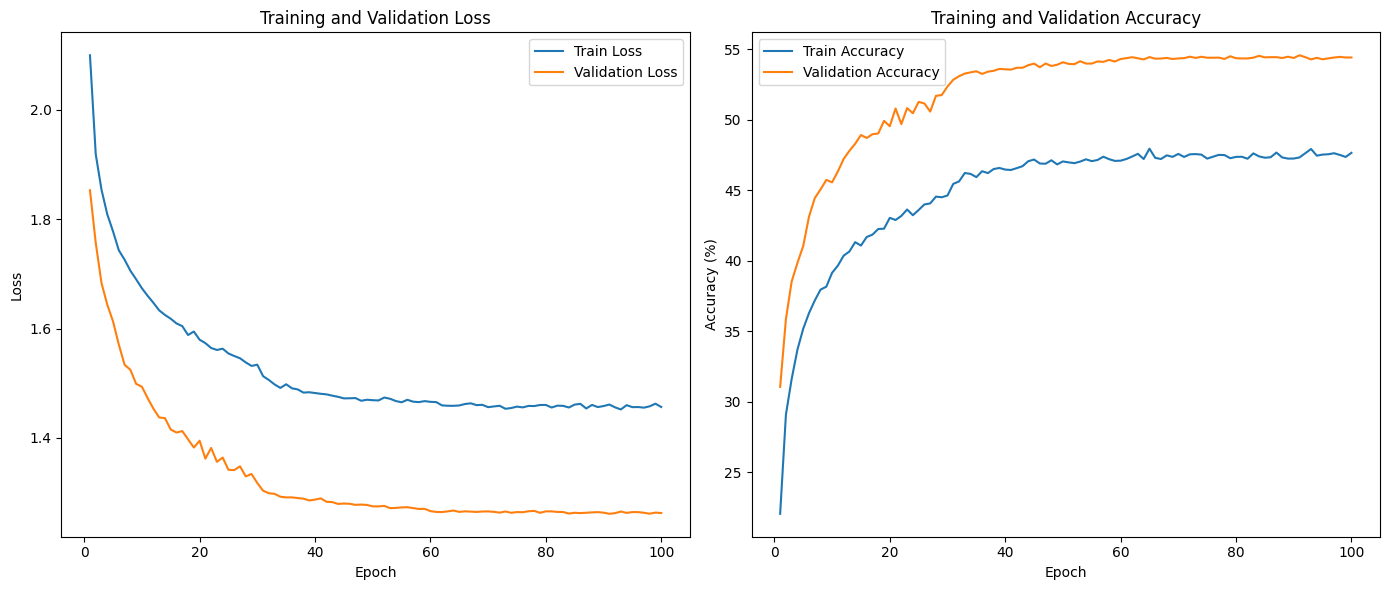

In [49]:
# Truncate the lists to the same length in case of early stopping
min_length = min(len(train_losses), len(val_losses), len(train_accuracies), len(val_accuracies))
train_losses = train_losses[:min_length]
val_losses = val_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_accuracies = val_accuracies[:min_length]

# Plot loss and accuracy
plt.figure(figsize=(14, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, min_length + 1), train_losses, label='Train Loss')
plt.plot(range(1, min_length + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, min_length + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, min_length + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout() # Ensure the plots do not overlap
plt.show()

Test Accuracy: 87.27%


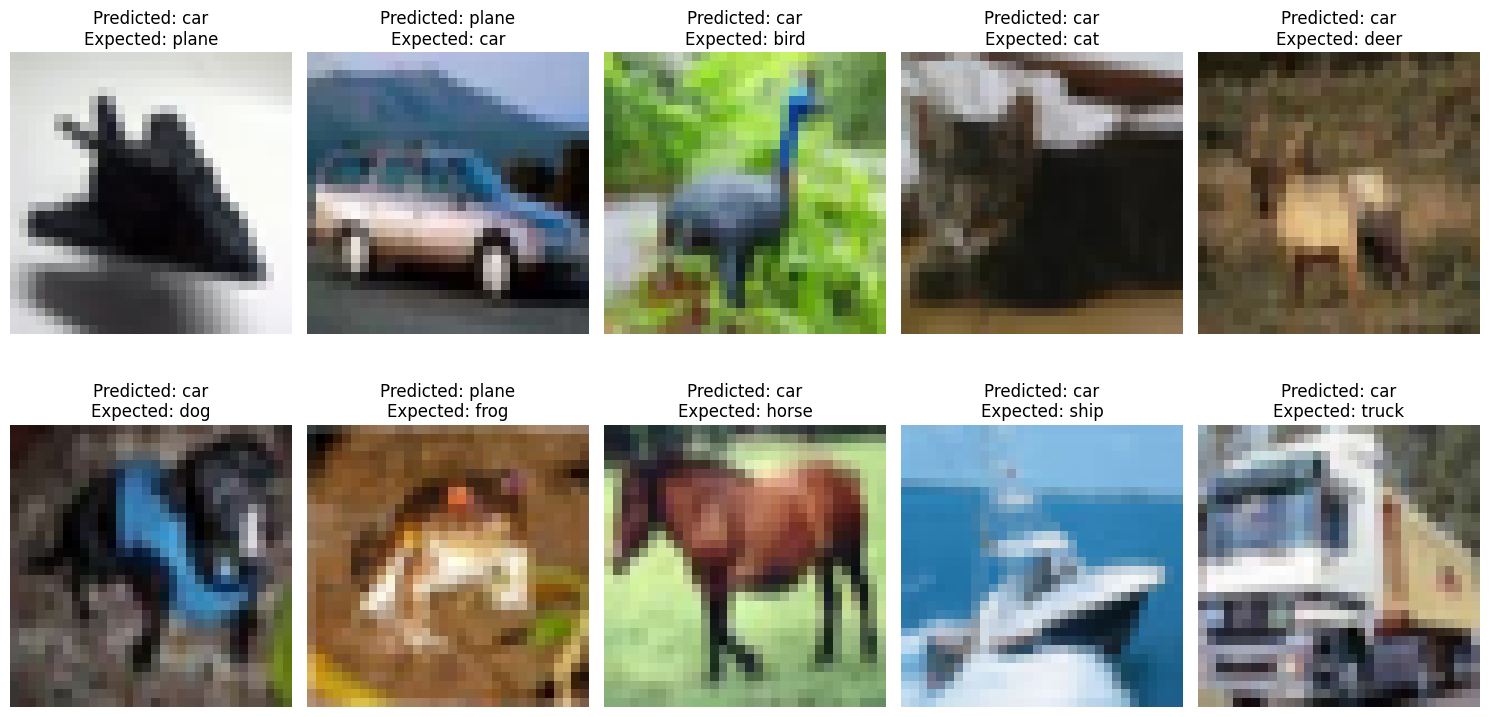

In [50]:
# Evaluate the model on the test set
correct = 0
total = 0
predictions = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.tolist())

# Print test accuracy
print('Test Accuracy: {:.2f}%'.format(100 * correct / total))

# Display one image for each class with its predicted and expected labels
class_images = {class_name: None for class_name in classes}
correct_predictions = {class_name: None for class_name in classes}

# Randomly select one image for each class
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            class_name = classes[labels[i]]
            if class_images[class_name] is None:
                class_images[class_name] = images[i]
                correct_predictions[class_name] = predicted[i].item() == labels[i].item()

# Display the images
plt.figure(figsize=(15, 8))
for i, (class_name, image) in enumerate(class_images.items()):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.transpose(image / 2 + 0.5, (1, 2, 0)))
    plt.title(f'Predicted: {classes[correct_predictions[class_name]]}\nExpected: {class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [60]:
# Modify more

In [69]:
batch_size = 128  # Reduced batch size
learning_rate = 0.001  # Lower learning rate
epochs = 150  # More epochs for better convergence
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [70]:
# Define Transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [71]:
train_indices, val_indices, test_indices = split_data(trainset)

In [72]:
# Create new datasets with appropriate transformations
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=val_test_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=val_test_transform)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [73]:
# Create DataLoaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


In [74]:
# Define MoreNeuronAndLayerNet with Dropout and Batch Normalization
class MoreNeuronAndLayerNet(nn.Module):
    def __init__(self):
        super(MoreNeuronAndLayerNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 2048)  # Increased number of neurons
        self.bn1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(2048, 1024)  # Increased number of neurons
        self.bn2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(512, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.2)
        
        self.fc5 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        
        x = self.fc5(x)
        return x

more_net = MoreNeuronAndLayerNet().to(device)


In [75]:
# Define Loss Function
criterion = nn.CrossEntropyLoss()

# Define Optimizer
optimizer = optim.Adam(more_net.parameters(), lr=learning_rate, weight_decay=1e-4)

# Define Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [76]:
# Training Loop with Early Stopping
best_val_loss = float('inf')
patience = 10  # Number of epochs to wait for improvement
patience_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    running_loss_train = 0.0
    running_loss_val = 0.0
    total_train = 0
    correct_train = 0
    total_val = 0
    correct_val = 0

    more_net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = more_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    more_net.eval()
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = more_net(images)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    train_losses.append(running_loss_train / len(trainloader))
    val_losses.append(running_loss_val / len(valloader))
    train_accuracies.append(100 * correct_train / total_train)
    val_accuracies.append(100 * correct_val / total_val)

    print(f'Epoch {epoch + 1}: Train Loss: {train_losses[-1]:.3f} | Train Accuracy: {train_accuracies[-1]:.2f}% | Validation Loss: {val_losses[-1]:.3f} | Validation Accuracy: {val_accuracies[-1]:.2f}%')

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(more_net.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping')
            break

    # Step the learning rate scheduler
    scheduler.step()

print('Finished Training')

Epoch 1: Train Loss: 1.843 | Train Accuracy: 32.71% | Validation Loss: 1.612 | Validation Accuracy: 41.54%
Epoch 2: Train Loss: 1.673 | Train Accuracy: 39.44% | Validation Loss: 1.552 | Validation Accuracy: 44.15%
Epoch 3: Train Loss: 1.612 | Train Accuracy: 41.64% | Validation Loss: 1.459 | Validation Accuracy: 47.24%
Epoch 4: Train Loss: 1.581 | Train Accuracy: 42.85% | Validation Loss: 1.446 | Validation Accuracy: 47.28%
Epoch 5: Train Loss: 1.558 | Train Accuracy: 43.38% | Validation Loss: 1.426 | Validation Accuracy: 48.60%
Epoch 6: Train Loss: 1.539 | Train Accuracy: 44.25% | Validation Loss: 1.406 | Validation Accuracy: 49.25%
Epoch 7: Train Loss: 1.528 | Train Accuracy: 44.68% | Validation Loss: 1.391 | Validation Accuracy: 49.61%
Epoch 8: Train Loss: 1.518 | Train Accuracy: 45.42% | Validation Loss: 1.354 | Validation Accuracy: 51.26%
Epoch 9: Train Loss: 1.505 | Train Accuracy: 45.86% | Validation Loss: 1.358 | Validation Accuracy: 50.77%
Epoch 10: Train Loss: 1.490 | Train A

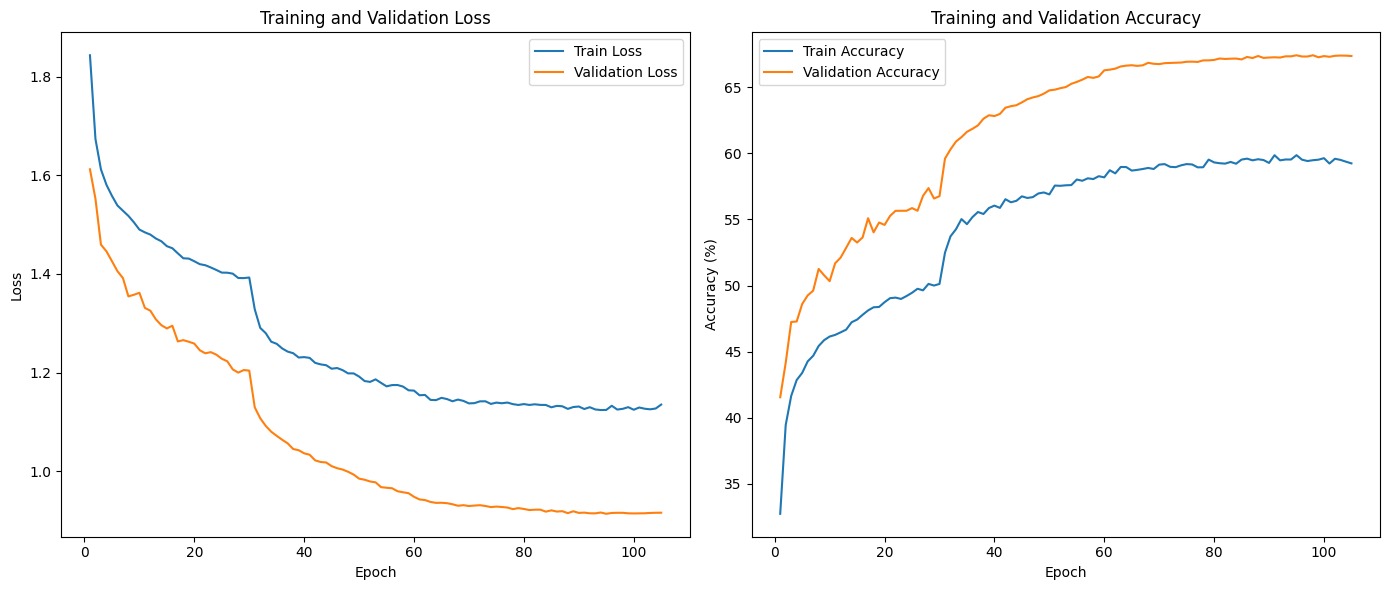

In [77]:
# Truncate the lists to the same length in case of early stopping
min_length = min(len(train_losses), len(val_losses), len(train_accuracies), len(val_accuracies))
train_losses = train_losses[:min_length]
val_losses = val_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_accuracies = val_accuracies[:min_length]

# Plot loss and accuracy
plt.figure(figsize=(14, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, min_length + 1), train_losses, label='Train Loss')
plt.plot(range(1, min_length + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, min_length + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, min_length + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout() # Ensure the plots do not overlap
plt.show()

Test Accuracy: 87.27%


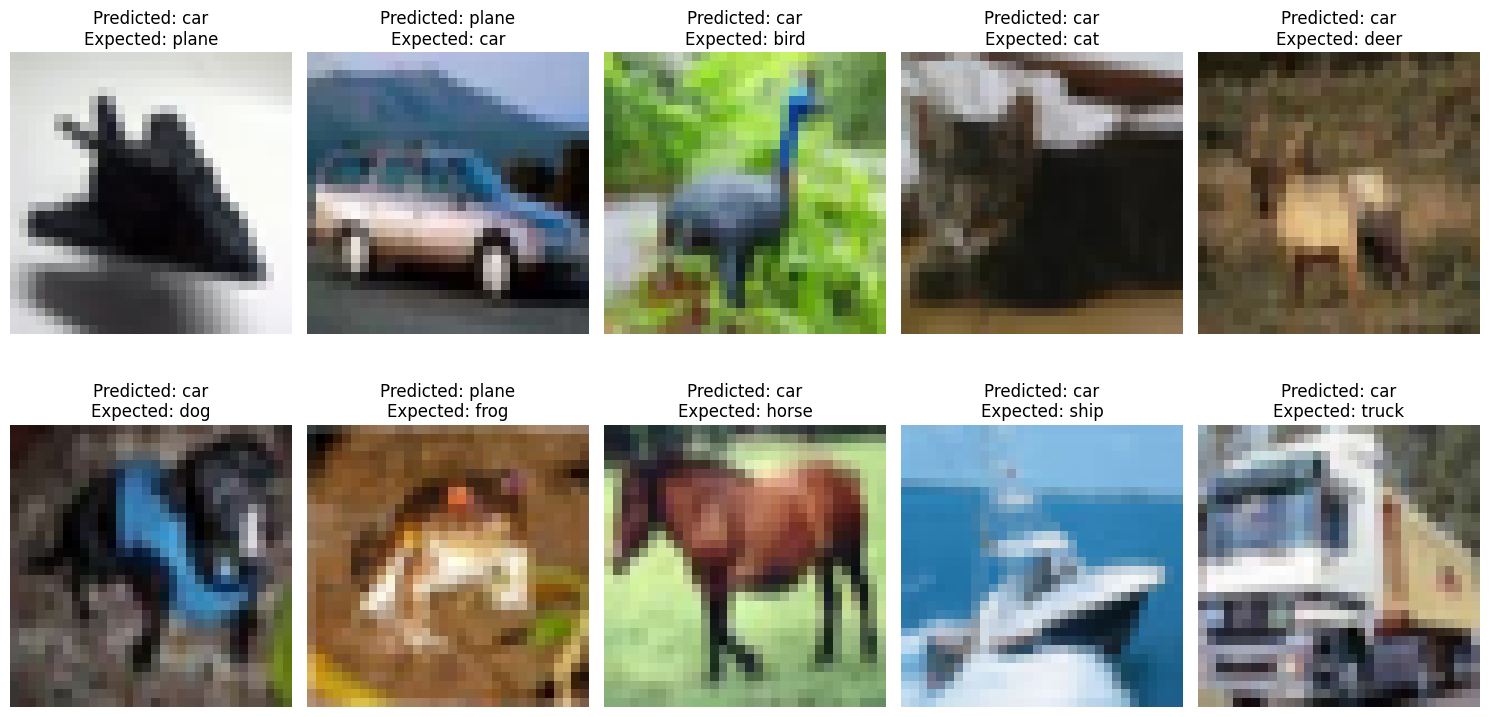

In [78]:
# Evaluate the model on the test set
correct = 0
total = 0
predictions = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.tolist())

# Print test accuracy
print('Test Accuracy: {:.2f}%'.format(100 * correct / total))

# Display one image for each class with its predicted and expected labels
class_images = {class_name: None for class_name in classes}
correct_predictions = {class_name: None for class_name in classes}

# Randomly select one image for each class
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            class_name = classes[labels[i]]
            if class_images[class_name] is None:
                class_images[class_name] = images[i]
                correct_predictions[class_name] = predicted[i].item() == labels[i].item()

# Display the images
plt.figure(figsize=(15, 8))
for i, (class_name, image) in enumerate(class_images.items()):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.transpose(image / 2 + 0.5, (1, 2, 0)))
    plt.title(f'Predicted: {classes[correct_predictions[class_name]]}\nExpected: {class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Conclusion

    Throughout many different techniques and optimization method, I may temporarily assume that with the suitable epoch number, batch and learning rate,... The model has been significantly improved from overfitting. The Adam optimization may work best with Regularization, early stopping, learning rate schedule, etc. With data augmentation, the datasets became various and the training and testing process might be more suitable and went along with each other: train by train and test by test. 

    In the future, I can improve this model more and more with the convolutional neural networks or the sequence model, I think there will be space for improvement.
